# 🖼️ Image Upscaler
### High-quality image upscaling using AI models

**Instructions:**
1. Run Setup cell
2. Configure settings
3. Upload model and images
4. Process and download!

In [1]:
#@title **1. Setup (Install & Import)** { display-mode: "form" }
print("Installing required packages...")
!pip install -q torch torchvision spandrel spandrel-extra-arches pillow numpy tqdm chaiNNer-ext
print("✓ Installation complete!\n")

print("Importing libraries...")
import os
import torch
from PIL import Image
import spandrel
import spandrel_extra_arches
import numpy as np
import time
import traceback
import gc
from tqdm import tqdm
import chainner_ext
from google.colab import files
import zipfile
from IPython.display import display

spandrel_extra_arches.install()
print("✓ Setup complete!")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.7 MB/s eta 0:00:00
✓ Installation complete!

Importing libraries...
✓ Setup complete!


In [6]:
#@title **2. Configuration Settings** { display-mode: "form" }
TILE_SIZE = "512" #@param ["256", "512", "1024", "native"] {type:"string"}
PRECISION = "auto" #@param ["auto", "fp32", "fp16", "bf16"] {type:"string"}
OUTPUT_FORMAT = "png" #@param ["png", "jpg", "webp"] {type:"string"}
ALPHA_HANDLING = "resize" #@param ["resize", "upscale", "discard"] {type:"string"}
GAMMA_CORRECTION = False #@param {type:"boolean"}

def upscale_tensor(img_tensor, model, tile_size):
    _, _, h, w = img_tensor.shape
    output_h, output_w = h * model.scale, w * model.scale
    output_dtype = torch.float32 if PRECISION == 'fp32' else torch.float16
    output_tensor = torch.zeros((1, img_tensor.shape[1], output_h, output_w), dtype=output_dtype, device='cuda')

    if tile_size == "native":
        tile_size = max(h, w)
    tile_size = int(tile_size)

    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = img_tensor[:, :, y:min(y+tile_size, h), x:min(x+tile_size, w)]
            with torch.inference_mode():
                if model.supports_bfloat16 and PRECISION in ['auto', 'bf16']:
                    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                        upscaled_tile = model(tile)
                elif model.supports_half and PRECISION in ['auto', 'fp16']:
                    with torch.autocast(device_type='cuda', dtype=torch.float16):
                        upscaled_tile = model(tile)
                else:
                    upscaled_tile = model(tile)
            output_tensor[:, :, y*model.scale:min((y+tile_size)*model.scale, output_h),
                          x*model.scale:min((x+tile_size)*model.scale, output_w)].copy_(upscaled_tile)
    return output_tensor

def load_model(model_path):
    if not os.path.exists(model_path):
        raise ValueError(f"Model file not found: {model_path}")
    model = spandrel.ModelLoader().load_from_file(model_path)
    if isinstance(model, spandrel.ImageModelDescriptor):
        return model.cuda().eval()
    else:
        raise ValueError(f"Invalid model type for {model_path}")

def upscale_image(image, model, tile_size, alpha_handling, gamma_correction):
    has_alpha = image.mode == 'RGBA'
    if has_alpha:
        rgb_image, alpha = image.convert('RGB'), image.split()[3]
    else:
        rgb_image = image

    rgb_tensor = torch.from_numpy(np.array(rgb_image)).permute(2, 0, 1).float().div_(255.0).unsqueeze(0).cuda()
    upscaled_rgb_tensor = upscale_tensor(rgb_tensor, model, tile_size)
    upscaled_rgb = Image.fromarray((upscaled_rgb_tensor[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

    if has_alpha:
        if alpha_handling == 'upscale':
            alpha_array = np.array(alpha)
            alpha_3channel = np.stack([alpha_array, alpha_array, alpha_array], axis=2)
            alpha_tensor = torch.from_numpy(alpha_3channel).permute(2, 0, 1).float().div_(255.0).unsqueeze(0).cuda()
            upscaled_alpha_tensor = upscale_tensor(alpha_tensor, model, tile_size)
            upscaled_alpha = Image.fromarray((upscaled_alpha_tensor[0, 0].cpu().numpy() * 255).astype(np.uint8))
        elif alpha_handling == 'resize':
            alpha_np = np.array(alpha, dtype=np.float32) / 255.0
            alpha_np = alpha_np.reshape(alpha_np.shape[0], alpha_np.shape[1], 1)
            upscaled_alpha_np = chainner_ext.resize(
                alpha_np, (upscaled_rgb.width, upscaled_rgb.height),
                chainner_ext.ResizeFilter.CubicMitchell, gamma_correction=gamma_correction
            )
            upscaled_alpha_np = np.clip(upscaled_alpha_np * 255, 0, 255)
            upscaled_alpha = Image.fromarray(upscaled_alpha_np.squeeze().astype(np.uint8))
        elif alpha_handling == 'discard':
            return upscaled_rgb
        upscaled_rgba = upscaled_rgb.copy()
        upscaled_rgba.putalpha(upscaled_alpha)
        return upscaled_rgba
    return upscaled_rgb

def process_image(input_path, output_path, model):
    try:
        image = Image.open(input_path)
        start_time = time.time()
        result = upscale_image(image, model, TILE_SIZE, ALPHA_HANDLING, GAMMA_CORRECTION)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        result.save(output_path, OUTPUT_FORMAT.upper())
        return time.time() - start_time
    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        traceback.print_exc()
        return None

print(f"✓ Configuration set:")
print(f"  • Tile Size: {TILE_SIZE}")
print(f"  • Precision: {PRECISION}")
print(f"  • Output Format: {OUTPUT_FORMAT}")
print(f"  • Alpha Handling: {ALPHA_HANDLING}")

✓ Configuration set:
  • Tile Size: 512
  • Precision: auto
  • Output Format: png
  • Alpha Handling: resize


In [3]:
#@title **3. Select or Upload Model** { display-mode: "form" }
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create models directory if it doesn't exist
models_dir = "/content/models"
os.makedirs(models_dir, exist_ok=True)

# Find existing models
existing_models = [f for f in os.listdir(models_dir) if f.endswith(('.pth', '.safetensors', '.pt', '.ckpt'))]

if existing_models:
    print(f"Found {len(existing_models)} previously uploaded model(s):\n")
    for i, model in enumerate(existing_models, 1):
        print(f"  {i}. {model}")
    print("\n" + "="*50)

USE_EXISTING = "Upload new model" #@param ["Use existing model", "Upload new model"] {type:"string"}

if USE_EXISTING == "Use existing model" and existing_models:
    SELECTED_MODEL = existing_models[0] #@param {type:"string"}
    # Create dropdown with existing models
    print(f"\n📋 Available models:")
    for i, model in enumerate(existing_models, 1):
        print(f"  {i}. {model}")

    model_choice = input(f"\nEnter model number (1-{len(existing_models)}): ")
    try:
        model_idx = int(model_choice) - 1
        if 0 <= model_idx < len(existing_models):
            model_filename = existing_models[model_idx]
            model_path = f"{models_dir}/{model_filename}"
            print(f"✓ Selected: {model_filename}")
        else:
            raise ValueError("Invalid selection")
    except:
        print("Invalid input, using first model")
        model_filename = existing_models[0]
        model_path = f"{models_dir}/{model_filename}"
        print(f"✓ Using: {model_filename}")
else:
    print("📁 Upload your model file (.pth, .safetensors, .pt, .ckpt)")
    uploaded_model = files.upload()

    if uploaded_model:
        model_filename = list(uploaded_model.keys())[0]
        # Save to models directory for future use
        with open(f"{models_dir}/{model_filename}", 'wb') as f:
            f.write(uploaded_model[model_filename])
        model_path = f"{models_dir}/{model_filename}"
        print(f"✓ Model uploaded and saved: {model_filename}")
    else:
        raise ValueError("No model uploaded!")

print(f"\n✓ Model ready: {model_filename}")

📁 Upload your model file (.pth, .safetensors, .pt, .ckpt)


Saving 2x-AnimeSharpV2_RPLKSR_Sharp.pth to 2x-AnimeSharpV2_RPLKSR_Sharp.pth
✓ Model uploaded and saved: 2x-AnimeSharpV2_RPLKSR_Sharp.pth

✓ Model ready: 2x-AnimeSharpV2_RPLKSR_Sharp.pth


In [4]:
#@title **4. Upload Images** { display-mode: "form" }
import shutil

input_dir = "/content/input_images"

# Check for existing images
existing_images = []
if os.path.exists(input_dir):
    existing_images = [f for f in os.listdir(input_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.tga', '.bmp', '.tiff'))]

if existing_images:
    print(f"⚠️  Found {len(existing_images)} previously uploaded image(s):")
    for img in existing_images[:5]:
        print(f"  • {img}")
    if len(existing_images) > 5:
        print(f"  ... and {len(existing_images) - 5} more")
    print("\n" + "="*50)

CLEAR_PREVIOUS = "Clear previous images" #@param ["Clear previous images", "Add to existing images"] {type:"string"}

if CLEAR_PREVIOUS == "Clear previous images" and os.path.exists(input_dir):
    shutil.rmtree(input_dir)
    print("🗑️  Cleared previous images\n")

print("📁 Upload images to upscale (PNG, JPG, JPEG, WEBP, TGA, BMP, TIFF)")
uploaded_images = files.upload()

if uploaded_images:
    os.makedirs(input_dir, exist_ok=True)
    for filename in uploaded_images.keys():
        with open(f"{input_dir}/{filename}", 'wb') as f:
            f.write(uploaded_images[filename])

    # Count total images now
    total_images = len([f for f in os.listdir(input_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.tga', '.bmp', '.tiff'))])
    print(f"✓ Uploaded {len(uploaded_images)} new image(s)")
    print(f"📊 Total images ready to process: {total_images}")
elif not existing_images:
    raise ValueError("No images uploaded!")
else:
    print(f"✓ Using {len(existing_images)} existing image(s)")

📁 Upload images to upscale (PNG, JPG, JPEG, WEBP, TGA, BMP, TIFF)


Saving 1-00_08_55.png to 1-00_08_55.png
Saving 1-00_12_44.png to 1-00_12_44.png
Saving 2-00_03_25.png to 2-00_03_25.png
Saving 2-00_10_02.png to 2-00_10_02.png
✓ Uploaded 4 new image(s)
📊 Total images ready to process: 4


In [7]:
#@title **5. Process Images** { display-mode: "form" }
output_dir = "/content/upscaled_images"
os.makedirs(output_dir, exist_ok=True)

print("Loading model...")
model = load_model(model_path)
print(f"✓ Model loaded! (Scale: {model.scale}x)\n")

image_files = [f for f in os.listdir("/content/input_images")
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.tga', '.bmp', '.tiff'))]

print(f"🚀 Processing {len(image_files)} image(s)...")
total_time = 0
successful = 0

for filename in tqdm(image_files, desc="Upscaling"):
    input_path = f"/content/input_images/{filename}"
    output_filename = os.path.splitext(filename)[0] + f'.{OUTPUT_FORMAT}'
    output_path = f"{output_dir}/{output_filename}"

    processing_time = process_image(input_path, output_path, model)
    if processing_time is not None:
        total_time += processing_time
        successful += 1

print(f"\n✓ Successfully processed {successful}/{len(image_files)} images")
print(f"⏱ Total time: {total_time:.2f}s")
if successful > 0:
    print(f"⏱ Average per image: {total_time/successful:.2f}s")

torch.cuda.empty_cache()
gc.collect()

Loading model...
✓ Model loaded! (Scale: 2x)

🚀 Processing 4 image(s)...


Upscaling: 100%|██████████| 4/4 [00:21<00:00,  5.48s/it]


✓ Successfully processed 4/4 images
⏱ Total time: 21.89s
⏱ Average per image: 5.47s


656

In [ ]:
#@title **6. Download Results** { display-mode: "form" }
print("📦 Creating download package...")
zip_filename = "upscaled_images.zip"
with zipfile.ZipFile(f"/content/{zip_filename}", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in os.listdir("/content/upscaled_images"):
        file_path = f"/content/upscaled_images/{filename}"
        zipf.write(file_path, filename)

print(f"✓ Package created: {zip_filename}")
print("⬇ Downloading...")
files.download(f"/content/{zip_filename}")
print("✓ Download complete!")

📷 Showing previews (4 images):


2-00_10_02.png - Size: (1440, 1080)


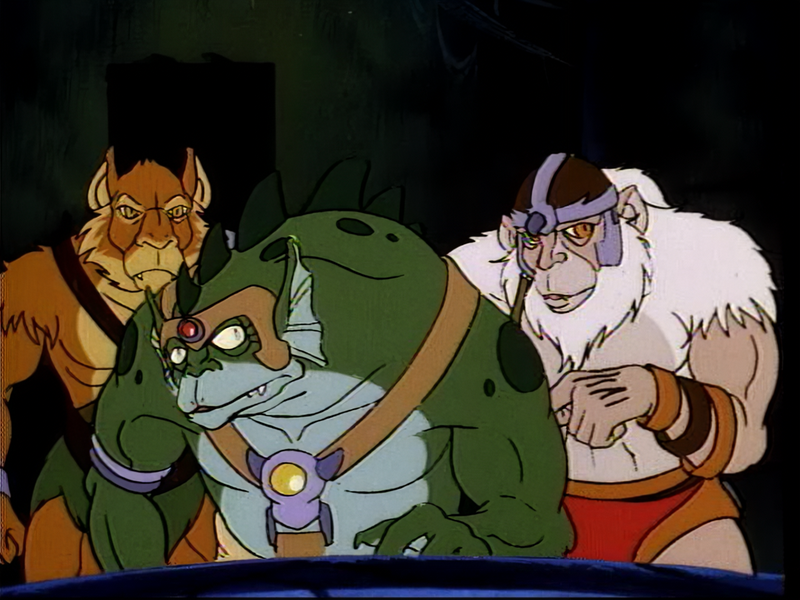


1-00_12_44.png - Size: (1440, 1080)


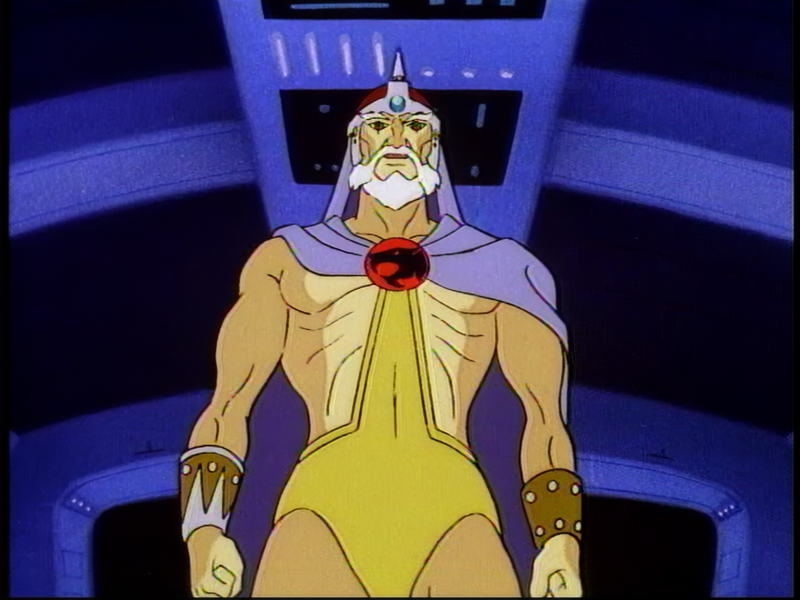


2-00_03_25.png - Size: (1440, 1080)


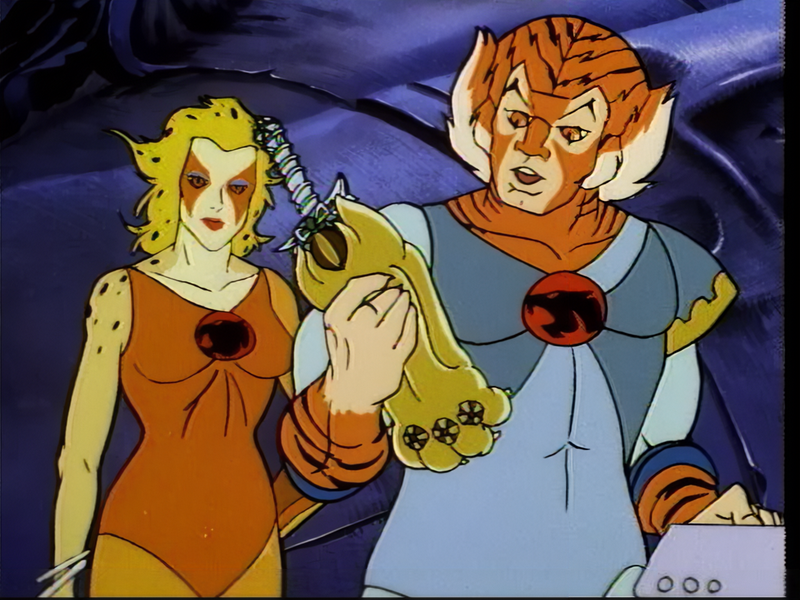


1-00_08_55.png - Size: (1440, 1080)


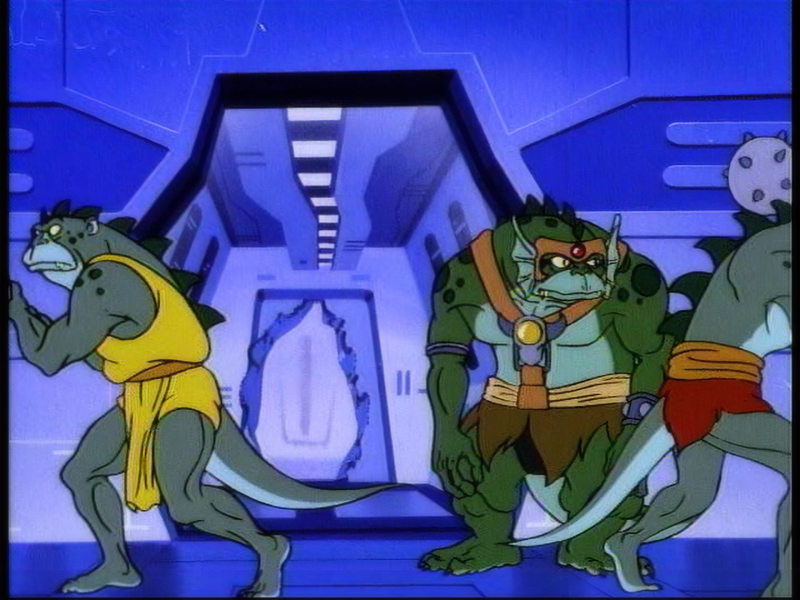

In [8]:
#@title **7. Preview Results (Optional)** { display-mode: "form" }
upscaled_files = [f for f in os.listdir("/content/upscaled_images")]
print(f"📷 Showing previews ({len(upscaled_files)} images):\n")

for filename in upscaled_files[:5]:
    img_path = f"/content/upscaled_images/{filename}"
    img = Image.open(img_path)

    max_preview_size = 800
    if max(img.size) > max_preview_size:
        ratio = max_preview_size / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)

    print(f"\n{filename} - Size: {Image.open(img_path).size}")
    display(img)

if len(upscaled_files) > 5:
    print(f"\n... and {len(upscaled_files) - 5} more images")